In [23]:
%aiida
from aiida import orm, load_profile
import matplotlib.pyplot as plt
from aiida.orm import QueryBuilder
from collections import Counter
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import ase
from math import pi
import numpy as np
from ase.atoms import Atoms
import asap3
from ase.calculators import calculator
from ase.calculators.calculator import Calculator, kpts2ndarray
from ase import Atoms
from operator import itemgetter 
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing 
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

In [2]:
#dataset load 
skip=100  #usually complete it is 79855
load_profile()
qb = QueryBuilder()
qb.append(orm.StructureData)
qb.count()
qb_red=qb.all()[::skip] #reduced dataset 

In [6]:
# some useful functions
def removeElements(lst): 
    counted = Counter(lst) 
    return [el for el in lst if counted[el] >= len(lst)/1000] 

def point_group(structure):
    global pg
    if sg==1: #spacegroup
        pg='1' #pointgroup
        o=1   #number of operations
    elif sg==2:
        pg='1_'
        o=2
    elif 3<=sg<=5:
        pg='2'
        o=2
    elif 6<=sg<=9:
        pg='m'
        o=2
    elif 10<=sg<=15:
        pg='2/m'
        o=4
    elif 16<=sg<=24:
        pg='222'
        o=4
    elif 25<=sg<=46:
        pg='mm2'
        o=4
    elif 47<=sg<=74:
        pg='mmm'
        o=8
    elif 75<=sg<=80:
        pg='4'
        o=4
    elif 81<=sg<=82:
        pg='4_'
        o=4
    elif 83<=sg<=88:
        pg='4/m'
        o=8
    elif 89<=sg<=98:
        pg='422'
        o=8
    elif 99<=sg<=110:
        pg='4mm'
        o=8
    elif 111<=sg<=122:
        pg='4_2m'
        o=8
    elif 123<=sg<=142:
        pg='4/mmm'
        o=16
    elif 143<=sg<=146:
        pg='3'
        o=3
    elif 147<=sg<=148:
        pg='m3_'
        o=6
    elif 149<=sg<=155:
        pg='32'
        o=6
    elif 156<=sg<=161:
        pg='3m'
        o=6
    elif 162<=sg<=167:
        pg='3_m'
        o=12
    elif 168<=sg<=173:
        pg='6'
        o=6
    elif sg==174:
        pg='6_'
        o=6
    elif 175<=sg<=176:
        pg='6/m'
        o=12
    elif 177<=sg<=182:
        pg='622'
        o=12
    elif 183<=sg<=186:
        pg='6mm'
        o=12
    elif 187<=sg<=190:
        pg='6_m2'
        o=12
    elif 191<=sg<=194:
        pg='6/mmm'
        o=24
    elif 195<=sg<=199:
        pg='23'
        o=12
    elif 200<=sg<=206:
        pg='m_3'
        o=24
    elif 207<=sg<=214:
        pg='432'
        o=24
    elif 215<=sg<=220:
        pg='4_3m'
        o=24
    elif 221<=sg<=230:
        pg='m3_m'
        o=48
    
    return (pg,o)

def magic_four(lista):
    idx=[l for l in range(len(lista)) if lista[l] %4==0]
    return idx

In [9]:
point_group_list=[]
n_atoms=[]

for [structure_data] in qb_red:
    if 'spacegroup_number' in structure_data.extras:
        sg=structure_data.extras['spacegroup_number']
        natom = len(structure_data.get_site_kindnames())
        atoms=structure_data.get_ase()
        number_electrons=sum(atoms.numbers)
        sp_group=point_group(sg)
        point_group_list.append(pg)
        n_atoms.append(natom)

[0.83333333 0.48       0.5        0.73295455 0.85714286 1.
 0.2        0.5        0.38235294 0.875      0.5        0.46153846
 0.41935484 0.66666667 1.         0.8        0.45       0.33333333
 0.85714286 0.25       0.46666667 0.75       0.25       0.07142857
 0.64285714 0.5        0.76923077 0.44117647 0.81818182 0.82758621
 0.79375   ] [0.85714286 0.49019608 0.53846154 0.73446328 0.875      1.
 0.33333333 0.6        0.4        0.88888889 0.66666667 0.5
 0.42857143 0.75       1.         0.83333333 0.47619048 0.5
 0.875      0.4        0.47826087 0.8        0.4        0.13333333
 0.66666667 0.54545455 0.78571429 0.44927536 0.83333333 0.83333333
 0.79503106]


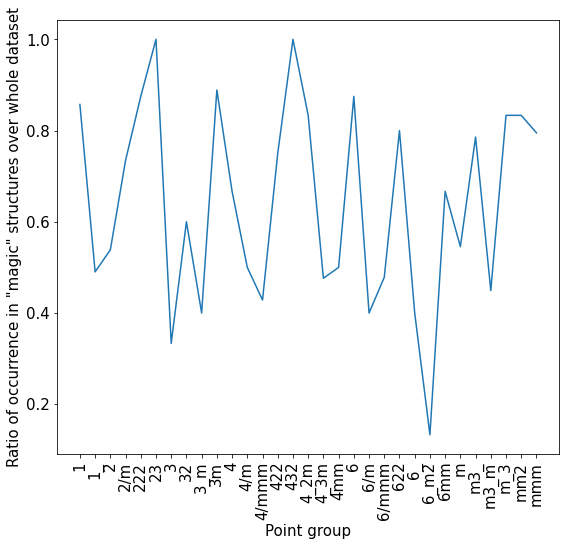

In [14]:
indexes=magic_four(n_atoms)
pg_magic=list(itemgetter(*indexes)(point_group_list))
n_atoms_magic = list(itemgetter(*indexes)(n_atoms))
pg1, pg_count = np.unique(point_group_list, return_counts=True)
pg2, pg_count_magic=np.unique(pg_magic, return_counts=True)
pg_count_magic=pg_count_magic.tolist()
pg_count_magic.insert(19,1)
pg_count_magic=np.asarray(pg_count_magic)
# divpg=[int(b) / int(m) for b,m in zip(pg_count_magic+1, pg_count+1)]
div_pg=(pg_count_magic)/(pg_count)
div_pg1=(pg_count_magic+1)/(pg_count+1)
print(div_pg, div_pg1)
plt.figure(figsize=(9,8))
plt.plot(pg1, div_pg1)
plt.xticks(rotation=90)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel('Point group', size=15)
plt.ylabel('Ratio of occurrence in "magic" structures over whole dataset', size=15)
plt.savefig("Rep of point groups.png", bbox_inches='tight', dpi=400)
plt.show()
plt.close()

In [39]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
df = {'number of atoms': n_atoms,
        'point group':point_group_list
        }

df_magic= {'number of atoms': n_atoms_magic,
        'point group':pg_magic
        }


# df['point group']=np.array(df['point group'])
# df['point group']=df['point group'].reshape(-1,1)

df['point group']=encoder.fit_transform(df['point group'])
df_magic['point group']=encoder.fit_transform(df_magic['point group'])
# df_magic['point group']=np.array(df_magic['point group'])
# df_magic['point group']=df_magic['point group'].reshape(-1,1)

df = pd.DataFrame(df,columns=['number of atoms', 'point group'])
df_magic= pd.DataFrame(df_magic,columns=['number of atoms', 'point group'])



# print(df['point group'])
print((df['point group']))
sns.set(style="white", palette="muted", color_codes=True)
f, ax = plt.subplots(figsize=(9, 10))
sns.despine(left=True)
sns.histplot(data=df['point group'], stat="probability", color='magenta', alpha=0.4, discrete=True, label='whole dataset')
sns.histplot(data=df_magic['point group'], stat="probability", color='orange', fill=False, discrete=True, label='only "magic" structures')
ax.tick_params(axis='both', which='major', labelsize=10)
# ax.set_yticklabels(size=20)
# ax.set_xticklabels(pg_magic, rotation=90, size=10)
# ax.set_xlim(-1, 100)
# ax.set_ylim(0, 0.1)
ax.set_xlabel('Point group')
ax.set_ylabel('Relative occurrence')
plt.legend()
plt.savefig('hist_point_gr.png', bbox_inches='tight', dpi=400)
plt.show()
plt.close()

print(len(y))

TypeError: fit_transform() missing 1 required positional argument: 'y'